In [1]:
# Labirinto modificado com geração dinâmica
import gc
import random
import numpy as np
import tracemalloc as tm
from time import perf_counter
from collections import deque
from typing import Iterable, Tuple, Dict, List

import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# GERAÇÃO DINÂMICA DO LABIRINTO
# ==============================

def gerar_labirinto(linhas: int, colunas: int) -> List[List[str]]:
    """Gera dinamicamente um labirinto de tamanho (linhas x colunas)
    utilizando algoritmo de backtracking recursivo.
    Retorna uma matriz contendo:
        '.' = Caminho livre
        '#' = Parede
        'S' = Início
        'G' = Objetivo
    """

    # Garante que as dimensões sejam ímpares
    if linhas % 2 == 0:
        linhas += 1
    if colunas % 2 == 0:
        colunas += 1

    # Inicializa grid preenchido com paredes
    labirinto = [['#' for _ in range(colunas)] for _ in range(linhas)]

    # Direções possíveis (movimento de duas células)
    direcoes = [(-2, 0), (0, 2), (2, 0), (0, -2)]

    def dentro_do_labirinto(x: int, y: int) -> bool:
        """Verifica se a posição está dentro dos limites internos."""
        return 0 < x < linhas - 1 and 0 < y < colunas - 1

    def criar_caminho(x: int, y: int):
        """Cria caminhos recursivamente a partir da posição (x, y)."""
        labirinto[x][y] = '.'
        direcoes_embaralhadas = direcoes.copy()
        random.shuffle(direcoes_embaralhadas)

        for dx, dy in direcoes_embaralhadas:
            nx, ny = x + dx, y + dy
            mx, my = x + dx // 2, y + dy // 2

            if dentro_do_labirinto(nx, ny) and labirinto[nx][ny] == '#':
                labirinto[mx][my] = '.'
                criar_caminho(nx, ny)

    criar_caminho(1, 1)

    labirinto[1][1] = 'S'
    labirinto[linhas - 2][colunas - 2] = 'G'

    return labirinto

# Função auxiliar para exibir o grid
def print_maze(grid):
    """Imprime o labirinto linha por linha."""
    for row in grid:
        print("".join(row))


# ==============================
# GERAÇÃO INICIAL DO LABIRINTO
# ==============================

maze = gerar_labirinto(10, 10)

print("\nLABIRINTO INICIAL GERADO:")
print("=" * len(maze[0]))
print_maze(maze)
print("=" * len(maze[0]))

# Encontrar caractere S e G (Start e Goal)
ROWS, COLS = len(maze), len(maze[0])


def find_char(grid, ch: str) -> Tuple[int, int]:
    """Encontra a primeira ocorrência do caractere `ch` no grid. Retorna (linha, coluna). Levanta ValueError se não encontrado."""
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            if grid[r][c] == ch:
                return (r, c)
    raise ValueError(f"Caractere {ch} não encontrado.")


start = find_char(maze, "S")
goal = find_char(maze, "G")

print(f"\nStart: {start}")
print(f"Goal: {goal}")


LABIRINTO INICIAL GERADO:
###########
#S..#...#.#
###.#.#.#.#
#.#...#.#.#
#.#####.#.#
#.#.....#.#
#.#.#####.#
#.#.#.....#
#.#.#.###.#
#.....#..G#
###########

Start: (1, 1)
Goal: (9, 9)


BFS: 0.00026346 segundos
DFS: 0.00031653 segundos


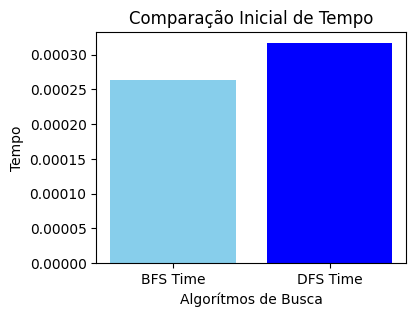

In [2]:
# Obter todos os estados
def neighbors(pos: Tuple[int, int], grid) -> Iterable[Tuple[int, int]]:
    """Retorna todos os vizinhos válidos (cima, baixo, esquerda, direita e diagonais) dentro dos limites e não bloqueados por parede."""
    r, c = pos
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, -1), (-1, 1), (1, 1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < len(grid) and 0 <= nc < len(grid[0]):
            if grid[nr][nc] != '#':
                yield (nr, nc)


list(neighbors(start, maze))


# Reconstruir caminho no grid
def reconstruct_path_grid(parent: Dict[Tuple[int, int], Tuple[int, int]], start, goal) -> List[Tuple[int, int]]:
    """Reconstrói o caminho do start ao goal usando o mapa de pais."""
    if goal not in parent and goal != start:
        return []
    path = [goal]
    cur = goal
    while cur != start:
        cur = parent[cur]
        path.append(cur)
    path.reverse()
    return path


# BFS no grid
def bfs_grid(grid, start, goal):
    """Executa busca em largura no grid do start ao goal. Retorna (found: bool, path)."""
    q = deque([start])
    visited = {start}
    parent = {}

    while q:
        u = q.popleft()
        if u == goal:
            return True, reconstruct_path_grid(parent, start, goal)

        for v in neighbors(u, grid):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                q.append(v)

    return False, []


# DFS no grid
def dfs_grid(grid, start, goal):
    """Executa busca em profundidade no grid do start ao goal. Retorna (found: bool, path)."""
    stack = [start]
    visited = {start}
    parent = {}

    while stack:
        u = stack.pop()
        if u == goal:
            return True, reconstruct_path_grid(parent, start, goal)

        for v in reversed(list(neighbors(u, grid))):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                stack.append(v)

    return False, []


# Aqui foi feito para testar o tempo de execução das funções BFS e DFS e gerar o primeiro gráfico
bfs_time_start = perf_counter()
found_bfs, path_bfs = bfs_grid(maze, start, goal)
bfs_time_end = perf_counter()
bfs_time = bfs_time_end - bfs_time_start

dfs_time_start = perf_counter()
found_dfs, path_dfs = dfs_grid(maze, start, goal)
dfs_time_end = perf_counter()
dfs_time = dfs_time_end - dfs_time_start

print(f'BFS: {bfs_time:.05} segundos')
print(f'DFS: {dfs_time:.05} segundos')

# Melhor grid executado pela última vez
plt.figure(figsize=(4, 3))
plt.bar(['BFS Time', 'DFS Time'], [bfs_time, dfs_time], color=['skyblue', 'blue'])
plt.xlabel('Algorítmos de Busca')
plt.ylabel('Tempo')
plt.title("Comparação Inicial de Tempo")
plt.show()

In [3]:
# ==============================
# FUNÇÃO DE MEDIÇÃO
# ==============================

def desempenho(maze, algoritmo, start, goal, modo="tempo"):
    """
    Mede tempo (ms) ou memória (KB) de um algoritmo de busca.
    """

    if modo == "tempo":
        inicio = perf_counter()
        algoritmo(maze, start, goal)
        fim = perf_counter()
        return (fim - inicio) * 1000  # milissegundos

    elif modo == "memoria":
        gc.collect()
        tm.start()
        algoritmo(maze, start, goal)
        _, peak = tm.get_traced_memory()
        tm.stop()
        return peak / 1024  # KB


# ==============================
# COLETA DOS RESULTADOS
# ==============================

resultados = []

for bigO in range(5):

    tamanho = 25 + bigO * 10
    maze = gerar_labirinto(tamanho, tamanho)
    start = find_char(maze, "S")
    goal = find_char(maze, "G")

    bfs_time = desempenho(maze, bfs_grid, start, goal, "tempo")
    dfs_time = desempenho(maze, dfs_grid, start, goal, "tempo")

    bfs_mem = desempenho(maze, bfs_grid, start, goal, "memoria")
    dfs_mem = desempenho(maze, dfs_grid, start, goal, "memoria")

    resultados.append({
        "Tamanho": tamanho,
        "BFS_Tempo_ms": bfs_time,
        "DFS_Tempo_ms": dfs_time,
        "BFS_Memoria_KB": bfs_mem,
        "DFS_Memoria_KB": dfs_mem
    })


# ==============================
# DATAFRAME
# ==============================

df_resultados = pd.DataFrame(resultados)

# Formatação para visualização
df_formatado = df_resultados.copy()

df_formatado["BFS_Tempo_ms"] = df_formatado["BFS_Tempo_ms"].map(lambda x: f"{x:.2f} ms")
df_formatado["DFS_Tempo_ms"] = df_formatado["DFS_Tempo_ms"].map(lambda x: f"{x:.2f} ms")
df_formatado["BFS_Memoria_KB"] = df_formatado["BFS_Memoria_KB"].map(lambda x: f"{x:.2f} KB")
df_formatado["DFS_Memoria_KB"] = df_formatado["DFS_Memoria_KB"].map(lambda x: f"{x:.2f} KB")


# ==============================
# MÉDIAS
# ==============================

medias = df_resultados.mean(numeric_only = True)

medias_formatadas = pd.DataFrame([{
    "BFS_Tempo_ms": f"{medias['BFS_Tempo_ms']:.2f} ms",
    "DFS_Tempo_ms": f"{medias['DFS_Tempo_ms']:.2f} ms",
    "BFS_Memoria_KB": f"{medias['BFS_Memoria_KB']:.2f} KB",
    "DFS_Memoria_KB": f"{medias['DFS_Memoria_KB']:.2f} KB"
}])

df_medias = pd.DataFrame(medias_formatadas).T.rename(columns={0: "Média"})

# ==============================
# EXIBIÇÃO
# ==============================

print("\n=== Resultados por Execução ===")
display(df_formatado)

print("\n=== Médias Gerais ===")
display(df_medias)


=== Resultados por Execução ===


,Tamanho,BFS_Tempo_ms,DFS_Tempo_ms,BFS_Memoria_KB,DFS_Memoria_KB
0,25,0.61 ms,1.51 ms,32.67 KB,38.33 KB
1,35,1.30 ms,1.92 ms,79.74 KB,86.31 KB
2,45,1.80 ms,3.75 ms,85.18 KB,128.57 KB
3,55,3.50 ms,4.04 ms,135.30 KB,136.85 KB
4,65,2.69 ms,6.55 ms,125.39 KB,316.05 KB



=== Médias Gerais ===


,Média
BFS_Tempo_ms,1.98 ms
DFS_Tempo_ms,3.56 ms
BFS_Memoria_KB,91.66 KB
DFS_Memoria_KB,141.22 KB


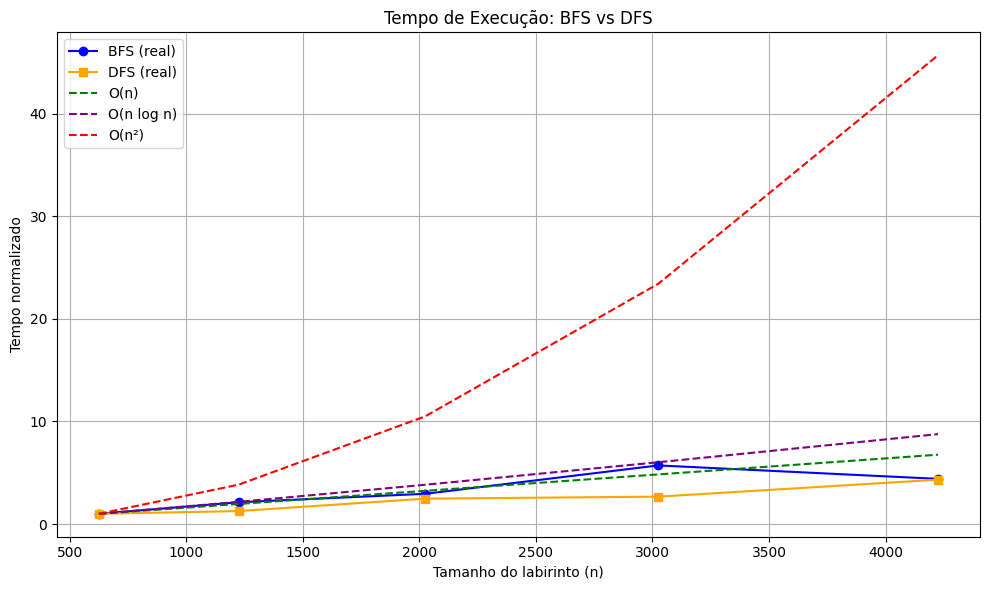

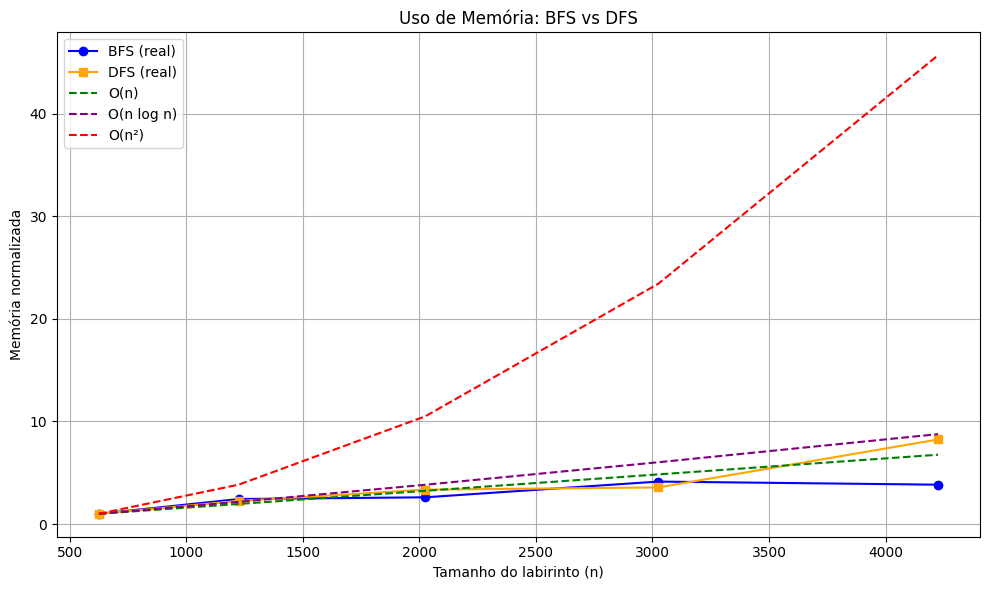

In [ ]:
# GRÁFICOS COM BIG O
# Precisamos transformar os dados para plotar as curvas teóricas de O(n), O(n log n) e O(n²) junto com os dados reais de tempo e memória.

# Curvas teóricas normalizadas
def normalizar(curve):
    """
    Normaliza uma curva de dados dividindo todos os seus valores pelo primeiro elemento.

    O resultado é uma curva que sempre começa em 1, permitindo comparar visualmente
    o crescimento relativo de diferentes curvas independentemente de suas unidades ou
    escalas originais (ex: milissegundos, KB, valores teóricos).

    Parâmetros:
        curve (np.ndarray): Array de valores numéricos a serem normalizados.

    Retorna:
        np.ndarray: Array normalizado onde o primeiro valor é sempre 1.

    Exemplo:
        >>> normalizar(np.array([10, 20, 40, 80]))
        array([1., 2., 4., 8.])
    """
    return curve / curve[0]


# Para isso começamos pegando os tamanhos dos labirintos usados
sizes = np.array(df_resultados["Tamanho"])

# Geramos as curvas teóricas normalizadas para entender como os tempos e memórias reais se comparam com as complexidades O(n), O(n log n) e O(n²)
o_n       = normalizar(sizes.astype(float))
o_n_log_n = normalizar(sizes * np.log2(sizes))
o_n2      = normalizar(sizes ** 2.0)

# --- GRÁFICO DE TEMPO ---
bfs_tempo_norm = normalizar(df_resultados["BFS_Tempo_ms"].values)
dfs_tempo_norm = normalizar(df_resultados["DFS_Tempo_ms"].values)

plt.figure(figsize=(10, 6))
plt.plot(sizes, bfs_tempo_norm, 'o-', label='BFS (real)', color='blue')
plt.plot(sizes, dfs_tempo_norm, 's-', label='DFS (real)', color='orange')
plt.plot(sizes, o_n,            '--', label='O(n)',        color='green')
plt.plot(sizes, o_n_log_n,      '--', label='O(n log n)',  color='purple')
plt.plot(sizes, o_n2,           '--', label='O(n²)',       color='red')
plt.title('Tempo de Execução: BFS vs DFS')
plt.xlabel('Tamanho do labirinto (n)')
plt.ylabel('Tempo normalizado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- GRÁFICO DE MEMÓRIA ---
bfs_mem_norm = normalizar(df_resultados["BFS_Memoria_KB"].values)
dfs_mem_norm = normalizar(df_resultados["DFS_Memoria_KB"].values)

plt.figure(figsize=(10, 6))
plt.plot(sizes, bfs_mem_norm, 'o-', label='BFS (real)', color='blue')
plt.plot(sizes, dfs_mem_norm, 's-', label='DFS (real)', color='orange')
plt.plot(sizes, o_n,          '--', label='O(n)',        color='green')
plt.plot(sizes, o_n_log_n,    '--', label='O(n log n)',  color='purple')
plt.plot(sizes, o_n2,         '--', label='O(n²)',       color='red')
plt.title('Uso de Memória: BFS vs DFS')
plt.xlabel('Tamanho do labirinto (n)')
plt.ylabel('Memória normalizada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()